In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
% matplotlib inline
import time
import os

plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/home/forever/anaconda3/lib/python3.5/site-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/home/forever/anaconda3/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


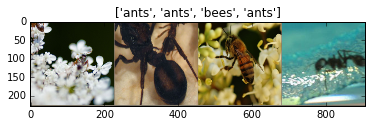

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/forever/.torch/models/resnet18-5c106cde.pth
100.0%


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1421 Acc: 0.7131
val Loss: 0.1214 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.1283 Acc: 0.7951
val Loss: 0.0743 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.1042 Acc: 0.8238
val Loss: 0.0675 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.1274 Acc: 0.8238
val Loss: 0.0847 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.1263 Acc: 0.7992
val Loss: 0.0868 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.1126 Acc: 0.8279
val Loss: 0.1566 Acc: 0.7582

Epoch 6/24
----------
train Loss: 0.1332 Acc: 0.8074
val Loss: 0.0776 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.0792 Acc: 0.8607
val Loss: 0.0622 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.0577 Acc: 0.8975
val Loss: 0.0530 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.0865 Acc: 0.8566
val Loss: 0.0576 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.0682 Acc: 0.9016
val Loss: 0.0518 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.0615 Acc: 0.8811
val Loss: 0.0543 Acc: 0.9150

Ep

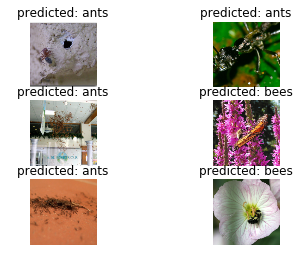

In [9]:
visualize_model(model_ft)

### freeze除了最后一个fc层其他所有的参数
### 会加快训练速度

In [11]:
model_ft = models.resnet18(pretrained=True)
for i in model_ft.parameters():
    i.requires_grad = False

model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1596 Acc: 0.6844
val Loss: 0.1362 Acc: 0.7255

Epoch 1/24
----------
train Loss: 0.1109 Acc: 0.8279
val Loss: 0.0475 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.1942 Acc: 0.7172
val Loss: 0.0957 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.1435 Acc: 0.7664
val Loss: 0.0711 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.1544 Acc: 0.7500
val Loss: 0.0475 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.0970 Acc: 0.8238
val Loss: 0.0467 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.1141 Acc: 0.7951
val Loss: 0.0586 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.1228 Acc: 0.7992
val Loss: 0.0510 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.1081 Acc: 0.8115
val Loss: 0.0657 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.0709 Acc: 0.8648
val Loss: 0.0664 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.0982 Acc: 0.8361
val Loss: 0.0495 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.1049 Acc: 0.7992
val Loss: 0.0638 Acc: 0.9281

Ep